# Predictive Modeling Project

## Overview
This project involves building and evaluating binary classification models. The code is structured to handle data preprocessing, address class imbalance, train multiple models, and perform a comprehensive evaluation using various metrics and explainability techniques.

## Key Features
- **Data Preprocessing**: Handles missing values and scales numerical / encodes categorical features using a `ColumnTransformer`.
- **Class Imbalance**: Utilizes techniques like SMOTE, ADASYN, and Random Oversampling to handle imbalanced datasets.
- **Model Training**: Employs `LogisticRegression` and `RandomForestClassifier` for prediction.
- **Comprehensive Evaluation**: Assesses models using accuracy, precision, recall, F1, ROC-AUC, PR-AUC, MCC, and confusion matrices.
- **Explainability**: Integrates SHAP (SHapley Additive exPlanations) for model interpretability.
- **Statistical Testing**: Includes functions for statistical validation of results (e.g., `ttest_ind`, `mannwhitneyu`).

In [ ]:
# ==================== IMPORTS ====================
import warnings
import os
import time
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, 
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    matthews_corrcoef, confusion_matrix,
    classification_report, roc_curve, auc,
    precision_recall_curve,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

import shap
from scipy.stats import ttest_ind, mannwhitneyu

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

d:\bioinfo\fob\pymol\Newfolder\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All required functions and directories.

In [ ]:


warnings.filterwarnings("ignore")
RESULTS_DIR = "results_combined"
output = "output"
os.makedirs(output,exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)



def load_filtered_data():
    """Load, filter, and return summary stats + p-values (cohort characteristics: age).
       Also logs number of individuals after each filter step and plots filter flow.
    """
    
    filter_counts = {}  # track counts
    
    # --- Load datasets ---
    df = pd.read_csv("data_participant.csv")
    demo = pd.read_csv("data_year_of_birth_and_ethnicity.csv")
    filter_counts["initial_loaded"] = len(df)
    
    # Ensure consistent ID format
    df['eid'] = df['eid'].astype(str).str.strip()
    demo['eid'] = demo['eid'].astype(str).str.strip()
    
    # Merge datasets
    df = df.merge(
        demo[['eid', 'p21022', 'p31', 'p40001_i1', 'p40006_i0', 'p40008_i0']],
        on='eid',
        how='left'
    )
    
    # --- Apply filters step by step ---
    # 1. Only males
    df = df[df['p31'] != 'Female'].copy()
    filter_counts["after_male_filter"] = len(df)
    
    # 2. Age > 50
    df = df[df['p21022'] > 50].copy()
    filter_counts["after_age50_filter"] = len(df)
    
    # 3. Exclude prostate cancer <=50
    df = df[~(
        (df['p40006_i0'].astype(str).str.contains("C61", na=False)) & 
        (df['p40008_i0'] <= 50)
    )].copy()
    filter_counts["after_exclude_pc_leq50"] = len(df)
    
    # Create target (prostate cancer yes/no)
    df['target'] = (
        df['p40001_i0'].str.contains('C61', na=False) |
        df['p40001_i1'].str.contains('C61', na=False)
    ).astype(int)
    filter_counts["final_cohort"] = len(df)
    
    # ---- Cohort Summary: Age ----
    def format_mean_sd(series):
        return f"{series.mean():.1f} ({series.std():.1f})"
    
    group0 = df.loc[df['target'] == 0, 'p21022']
    group1 = df.loc[df['target'] == 1, 'p21022']
    
    # t-test
    _, p_age = ttest_ind(group0, group1, nan_policy='omit')
    
    # Build summary table
    summary = pd.DataFrame([{
        "Characteristic": "Age at baseline, mean (s.d.), years",
        "Group0 (target=0)": format_mean_sd(group0),
        "Group1 (target=1)": format_mean_sd(group1),
        "P-value": f"{p_age:.3f}" + (" *" if p_age < 0.05 else "")
    }])
    
    # Save table
    summary.to_csv("cohort_characteristics.csv", index=False)
    
    # ---- Plot counts + mean ages ----
    counts = df.groupby('target').size()
    mean_ages = df.groupby('target')['p21022'].mean()
    
    fig, ax = plt.subplots()
    bars = ax.bar(counts.index.astype(str), counts.values, color=['steelblue', 'tomato'])
    
    for i, bar in enumerate(bars):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"Mean Age: {mean_ages.iloc[i]:.1f}",
            ha='center', va='bottom',
            fontsize=10, fontweight='bold'
        )
    
    ax.set_xlabel("Target (0 = Negative, 1 = Positive)")
    ax.set_ylabel("Count")
    ax.set_title("Target Counts with Mean Age")
    
    plt.savefig("target_counts_mean_age.png", dpi=300, bbox_inches="tight")
    plt.close()
    
    # ---- Plot filter flow ----
    steps = list(filter_counts.keys())
    sizes = list(filter_counts.values())
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(range(len(steps)), sizes, marker='o', linestyle='-', color='steelblue')
    ax.set_xticks(range(len(steps)))
    ax.set_xticklabels(steps, rotation=30, ha='right')
    ax.set_ylabel("Number of individuals")
    ax.set_title("Cohort Size After Each Filter Step")
    
    # Annotate counts
    for i, c in enumerate(sizes):
        ax.text(i, c, str(c), ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig("filter_flow.png", dpi=300, bbox_inches="tight")
    plt.close()
    
    # Print counts for transparency
    print("Filter counts:")
    for step, n in filter_counts.items():
        print(f"{step}: {n}")
    
    return df, summary, filter_counts


# ==================== FEATURE ENGINEERING ====================
def extract_all_features(df):
    """Robust feature extraction with consistent preprocessing"""
    # Biochemical features
    biochem_cols = [col for col in df.columns 
                   if col.startswith("p3") and pd.api.types.is_numeric_dtype(df[col])]
    
    # Date duration features
    date_cols = [col for col in df.columns if col.startswith("p1")]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors="coerce")
        df[col + "_dur"] = (2006 - df[col].dt.year).clip(lower=0)
    dur_cols = [col + "_dur" for col in date_cols if col + "_dur" in df.columns]
    
    # Other features
    numerical = ['p21001_i0', 'p21002_i0', 'p48_i0', 'p50_i0', 'p47_i0']
    categorical = ['p20116_i0', 'p1618_i0', 'p3637_i0']
    
    # Create preprocessing pipeline
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numerical + biochem_cols + dur_cols),
        ('cat', categorical_transformer, categorical)
    ])
    
    # Apply preprocessing
    X = df.drop(columns=['target'])
    y = df['target']
    X_processed = preprocessor.fit_transform(X)
    
    # Get feature names
    numeric_features = numerical + biochem_cols + dur_cols
    categorical_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical)
    feature_names = numeric_features + list(categorical_features)
    
    return X_processed, y, feature_names

# ==================== DATA SPLITTING ====================
from sklearn.model_selection import train_test_split
import pandas as pd

def training_split(x, y, eids):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    mask = ~y.isna()
    x = x[mask]
    y = y[mask]
    eids = eids[mask]

    X_train, X_test, y_train, y_test, eids_train, eids_test = train_test_split(
        x, y, eids,
        test_size=0.20,
        random_state=42,
        shuffle=True,
        stratify=y
    )

    return X_train, X_test, y_train, y_test, eids_train, eids_test

def hyper_optimize(X_train, y_train):
    """Train-validation split for hyperparameter tuning"""
    X_training, X_cv, y_training, y_cv = train_test_split(
        X_train, y_train,
        test_size=0.25,
        random_state=42,
        shuffle=True,
        stratify=y_train
    )
    return X_training, X_cv, y_training, y_cv

# ==================== CLASS BALANCING ====================
import numpy as np
import math

def balance_train_data(X_train, y_train):
    # Convert to numpy arrays if needed
    if hasattr(X_train, "values"):
        X_train = X_train.values
    if hasattr(y_train, "values"):
        y_train = y_train.values

    # Count positives and negatives
    pos_mask = (y_train == 1)
    neg_mask = (y_train == 0)
    n_pos = np.sum(pos_mask)
    n_neg = np.sum(neg_mask)

    # If balanced or no positives, return original
    if n_pos == 0 or n_neg <= n_pos:
        return X_train, y_train

    # Calculate how many times to multiply positives
    ratio = math.ceil(n_neg / n_pos)

    # Extract positive and negative samples
    X_pos = X_train[pos_mask]
    y_pos = y_train[pos_mask]
    X_neg = X_train[neg_mask]
    y_neg = y_train[neg_mask]

    # Repeat positives
    X_pos_upsampled = np.tile(X_pos, (ratio, 1))
    y_pos_upsampled = np.tile(y_pos, ratio)

    # Combine negatives and upsampled positives
    X_balanced = np.vstack([X_neg, X_pos_upsampled])
    y_balanced = np.hstack([y_neg, y_pos_upsampled])

    return X_balanced, y_balanced


# ==================== MODEL TRAINING ====================
def train_model(training_data, training_labels, testing_data, testing_labels):
    """Optimized training with early stopping and efficient preprocessing"""
    # Combined imputation and scaling in one step
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    X_train_processed = preprocessor.fit_transform(training_data)
    X_test_processed = preprocessor.transform(testing_data)
    
    # Optimized Logistic Regression
    classifier = LogisticRegression(
        class_weight='balanced',
        max_iter=500,  # Reduced with early stopping
        solver='saga',
        penalty='elasticnet',
        l1_ratio=0.5,
        random_state=42,
        n_jobs=-1,  # Use all cores
        tol=1e-3,  # Slightly looser tolerance
        warm_start=True  # For faster calibration
    )
    
    # Faster calibration with fewer folds
    calibrated = CalibratedClassifierCV(
        classifier,
        method='sigmoid',  # Faster than isotonic
        cv=3,
        n_jobs=-1
    )
    
    # Fit with early stopping check
    calibrated.fit(X_train_processed, training_labels)
    
    # Optimized threshold finding
    probs = calibrated.predict_proba(X_test_processed)[:, 1]
    precision, recall, thresholds = precision_recall_curve(testing_labels, probs)
    f1_scores = 2 * (precision * recall) / (np.maximum(precision + recall, 1e-9))
    best_thresh = thresholds[np.nanargmax(f1_scores)]  # Safer argmax
    
    return {"LogisticRegression": calibrated}, {"LogisticRegression": (probs >= best_thresh).astype(int)}


# ==================== FEATURE IMPORTANCE ====================
def get_and_save_top_features_logreg(model, feature_names, n_top_features=25, output_dir="output", model_name="LogisticRegression"):
    import os
    import numpy as np
    import pandas as pd
    
    os.makedirs(output_dir, exist_ok=True)

    # If model is wrapped in CalibratedClassifierCV, get the base estimator
    if hasattr(model, "base_estimator_"):
        model = model.base_estimator_

    if not hasattr(model, "coef_"):
        raise ValueError(f"Model {model_name} does not have coef_ attribute")

    # Get absolute coefficient values
    coefs = model.coef_[0]  # Binary classification
    abs_coefs = np.abs(coefs)

    # Sort by importance
    top_indices = np.argsort(abs_coefs)[::-1][:n_top_features]
    top_features_df = pd.DataFrame({
        "feature": np.array(feature_names)[top_indices],
        "importance": abs_coefs[top_indices]
    })

    # Save to CSV
    csv_path = os.path.join(output_dir, f"top_features_{model_name}.csv")
    top_features_df.to_csv(csv_path, index=False)

    return top_features_df

# ==================== PROGRESSIVE FEATURE ADDITION ====================




def progressive_feature_addition_logreg(model, top_features_df, X_train, y_train, X_test, y_test, feature_names,
                                        output_path_auc="progressive_features_auc.png",
                                        output_path_mcc="progressive_features_mcc.png"):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.base import clone
    from sklearn.metrics import roc_auc_score, matthews_corrcoef

    train_auc_list = []
    test_auc_list = []
    train_mcc_list = []
    test_mcc_list = []
    feature_counts = []

    top_features = top_features_df['feature'].tolist()

    for n in range(1, len(top_features) + 1):
        selected_features = top_features[:n]

        # Keep only features that exist
        selected_features = [f for f in selected_features if f in feature_names]
        if not selected_features:
            print(f"Step {n}: No matching features found, skipping.")
            continue

        # Select columns depending on X type
        if isinstance(X_train, np.ndarray):
            X_train_subset = X_train[:, [feature_names.index(f) for f in selected_features]]
            X_test_subset = X_test[:, [feature_names.index(f) for f in selected_features]]
        else:
            X_train_subset = X_train[selected_features]
            X_test_subset = X_test[selected_features]

        # Train cloned model
        model_clone = clone(model)
        model_clone.fit(X_train_subset, y_train)

        # Predict probabilities & binary outputs
        train_probs = model_clone.predict_proba(X_train_subset)[:, 1]
        test_probs = model_clone.predict_proba(X_test_subset)[:, 1]
        train_preds = (train_probs >= 0.5).astype(int)
        test_preds = (test_probs >= 0.5).astype(int)

        # Metrics
        train_auc = roc_auc_score(y_train, train_probs)
        test_auc = roc_auc_score(y_test, test_probs)
        train_mcc = matthews_corrcoef(y_train, train_preds)
        test_mcc = matthews_corrcoef(y_test, test_preds)

        train_auc_list.append(train_auc)
        test_auc_list.append(test_auc)
        train_mcc_list.append(train_mcc)
        test_mcc_list.append(test_mcc)
        feature_counts.append(len(selected_features))

    # --------------------
    # Plot AUC
    # --------------------
    plt.figure(figsize=(8, 6))
    plt.plot(feature_counts, train_auc_list, marker='o', label='Train AUC', color='tab:blue')
    plt.plot(feature_counts, test_auc_list, marker='o', label='Test AUC', color='tab:cyan')
    plt.xlabel('Number of Features')
    plt.ylabel('AUC')
    plt.title('Progressive Feature Addition - AUC (Logistic Regression)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_path_auc)
    plt.close()

    # --------------------
    # Plot MCC
    # --------------------
    plt.figure(figsize=(8, 6))
    plt.plot(feature_counts, train_mcc_list, marker='s', label='Train MCC', color='tab:red')
    plt.plot(feature_counts, test_mcc_list, marker='s', label='Test MCC', color='tab:orange')
    plt.xlabel('Number of Features')
    plt.ylabel('MCC')
    plt.title('Progressive Feature Addition - MCC (Logistic Regression)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_path_mcc)
    plt.close()

    return {
        "feature_counts": feature_counts,
        "train_auc": train_auc_list,
        "test_auc": test_auc_list,
        "train_mcc": train_mcc_list,
        "test_mcc": test_mcc_list,
        "auc_plot": output_path_auc,
        "mcc_plot": output_path_mcc
    }
# ==================== METRICS CALCULATION ====================
def get_metrics(testing_labels, predictions, probas=None):
    """Comprehensive metric calculation"""
    cm = confusion_matrix(testing_labels, predictions)
    report = classification_report(testing_labels, predictions, output_dict=True)
    
    metrics = {
        'confusion_matrix': cm,
        'accuracy': accuracy_score(testing_labels, predictions),
        'balanced_accuracy': balanced_accuracy_score(testing_labels, predictions),
        'precision': precision_score(testing_labels, predictions),
        'recall': recall_score(testing_labels, predictions),
        'f1': f1_score(testing_labels, predictions),
        'mcc': matthews_corrcoef(testing_labels, predictions),
        'roc_auc': roc_auc_score(testing_labels, probas) if probas is not None else np.nan,
        'classification_report': report
    }
    
    return metrics



def plot_model_metrics(model, X_train, y_train, X_test, y_test, output_dir="output", model_name="model"):
    """Plots AUC, MCC, and confusion matrix for a trained model and saves plots.

    Parameters
    ----------
    model : trained classifier
        Must implement predict_proba and predict
    X_train, y_train : array-like
        Training features and labels
    X_test, y_test : array-like
        Test features and labels
    output_dir : str
        Directory to save output plots
    model_name : str
        Name used in saved filenames
    """
    os.makedirs(output_dir, exist_ok=True)

    # Probabilities and predictions
    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]
    train_pred = (train_proba >= 0.5).astype(int)
    test_pred = (test_proba >= 0.5).astype(int)

    # Metrics
    train_auc = roc_auc_score(y_train, train_proba)
    test_auc = roc_auc_score(y_test, test_proba)
    train_mcc = matthews_corrcoef(y_train, train_pred)
    test_mcc = matthews_corrcoef(y_test, test_pred)

    # ---- Plot AUC & MCC ----
    plt.figure(figsize=(8, 6))
    x_labels = ["Train", "Test"]
    plt.plot(x_labels, [train_auc, test_auc], marker='o', label="AUC", color='blue')
    plt.plot(x_labels, [train_mcc, test_mcc], marker='s', label="MCC", color='orange')
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title(f"AUC & MCC - {model_name}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{model_name}_auc_mcc.png"), dpi=300)
    plt.close()

    # ---- Confusion Matrix ----
    cm = confusion_matrix(y_test, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(os.path.join(output_dir, f"{model_name}_confusion_matrix.png"), dpi=300)
    plt.close()

    return {
        "train_auc": train_auc, "test_auc": test_auc,
        "train_mcc": train_mcc, "test_mcc": test_mcc
    }




    # Function to evaluate and plot for train/val
def retrain_logreg_top_features_cv(
    top_features_df, X_train_bal, y_train_bal, 
    X_val, y_val, feature_names, 
    n_features=22, output_dir="output",
    eids_val=None  # Optional, to track sample IDs if you have them
):
    os.makedirs(output_dir, exist_ok=True)

    selected_features = top_features_df['feature'].head(n_features).tolist()
    selected_features = [f for f in selected_features if f in feature_names]
    print(f"Training with top {len(selected_features)} features: {selected_features}")

    if isinstance(X_train_bal, np.ndarray):
        X_train_subset = X_train_bal[:, [feature_names.index(f) for f in selected_features]]
        X_val_subset = X_val[:, [feature_names.index(f) for f in selected_features]]
    else:
        X_train_subset = X_train_bal[selected_features]
        X_val_subset = X_val[selected_features]

    model = LogisticRegression(max_iter=500, solver='liblinear')
    model.fit(X_train_subset, y_train_bal)

    def evaluate_and_plot(X_data, y_data, split_name, eids=None):
        probs = model.predict_proba(X_data)[:, 1]
        preds = (probs >= 0.5).astype(int)

        auc_score = roc_auc_score(y_data, probs)
        mcc_score = matthews_corrcoef(y_data, preds)

        print(f"\n--- {split_name} ---")
        print(f"AUC: {auc_score:.4f}")
        print(f"MCC: {mcc_score:.4f}")
        print(f"Total samples: {len(y_data)}")
        print(f"Predicted positives: {preds.sum()}, Predicted negatives: {(1 - preds).sum()}")
        print("Classification Report:")
        print(classification_report(y_data, preds))
        print("Confusion Matrix:")
        cm = confusion_matrix(y_data, preds)
        print(cm)

        # Identify false negatives and false positives
        fn_indices = [i for i, (yt, yp) in enumerate(zip(y_data, preds)) if yt == 1 and yp == 0]
        fp_indices = [i for i, (yt, yp) in enumerate(zip(y_data, preds)) if yt == 0 and yp == 1]

        print(f"False negatives (count={len(fn_indices)}): indices {fn_indices[:10]}{'...' if len(fn_indices)>10 else ''}")
        if eids is not None:
            fn_ids = [eids[i] for i in fn_indices[:10]]
            print(f"False negative IDs (sample): {fn_ids}")

        print(f"False positives (count={len(fp_indices)}): indices {fp_indices[:10]}{'...' if len(fp_indices)>10 else ''}")
        if eids is not None:
            fp_ids = [eids[i] for i in fp_indices[:10]]
            print(f"False positive IDs (sample): {fp_ids}")

        # Look at predicted probabilities near threshold for FN and FP
        if len(fn_indices) > 0:
            fn_probs = probs[fn_indices]
            print(f"False negative probabilities (sample): {fn_probs[:10]}")
        if len(fp_indices) > 0:
            fp_probs = probs[fp_indices]
            print(f"False positive probabilities (sample): {fp_probs[:10]}")

        # Try different thresholds (optional)
        thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
        for thresh in thresholds:
            preds_thresh = (probs >= thresh).astype(int)
            cm_thresh = confusion_matrix(y_data, preds_thresh)
            print(f"Threshold {thresh:.2f} Confusion Matrix:\n{cm_thresh}")

        # ROC

        fpr, tpr, _ = roc_curve(y_data, probs)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"{split_name} ROC (AUC={auc_score:.3f})", color="blue")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({split_name})")
        plt.legend()
        plt.grid(True)
        plt.text(0.65, 0.15, f"MCC={mcc_score:.3f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
        plt.savefig(f"{output_dir}/logreg_top{n_features}_{split_name.lower()}_roc.png")
        plt.close()

        # PR curve
        precision, recall, _ = precision_recall_curve(y_data, probs)
        pr_auc = auc(recall, precision)
        plt.figure(figsize=(6, 5))
        plt.plot(recall, precision, label=f"{split_name} PR (AUC={pr_auc:.3f})", color="green")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve ({split_name})")
        plt.legend()
        plt.grid(True)
        plt.text(0.65, 0.15, f"MCC={mcc_score:.3f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
        plt.savefig(f"{output_dir}/logreg_top{n_features}_{split_name.lower()}_pr.png")
        plt.close()

        return {
            "AUC": auc_score,
            "MCC": mcc_score,
            "PR_AUC": pr_auc
        }

    results = {}
    results["train"] = evaluate_and_plot(X_train_subset, y_train_bal, "Training")
    results["validation"] = evaluate_and_plot(X_val_subset, y_val, "Validation", eids_val)

    return model, selected_features, results



from imblearn.over_sampling import SMOTE

def retrain_logreg_top_features_test(
    top_features_df, X_train, y_train, X_test, y_test, feature_names,
    n_features=22, output_dir="output",
    eids_test=None  # Optional sample IDs
):
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import (
        roc_auc_score, matthews_corrcoef, accuracy_score,
        classification_report, confusion_matrix,
        roc_curve, precision_recall_curve, auc
    )
    from imblearn.over_sampling import SMOTE

    os.makedirs(output_dir, exist_ok=True)

    selected_features = top_features_df['feature'].head(n_features).tolist()
    selected_features = [f for f in selected_features if f in feature_names]
    print(f"Training with top {len(selected_features)} features: {selected_features}")

    if isinstance(X_train, np.ndarray):
        X_train_subset = X_train[:, [feature_names.index(f) for f in selected_features]]
        X_test_subset = X_test[:, [feature_names.index(f) for f in selected_features]]
    else:
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]

    # --------------------------
    # Apply SMOTE to balance classes
    # --------------------------
    sm = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = sm.fit_resample(X_train_subset, y_train)

    print(f"After SMOTE: {X_train_balanced.shape}, {sum(y_train_balanced)} positives")

    # --------------------------
    # Train model
    # --------------------------
    model = LogisticRegression(max_iter=500, solver='liblinear')
    model.fit(X_train_balanced, y_train_balanced)

    # --------------------------
    # Evaluation function
    # --------------------------
    def evaluate_and_plot(X_data, y_data, split_name, eids=None):
        probs = model.predict_proba(X_data)[:, 1]
        preds = (probs >= 0.5).astype(int)

        auc_score = roc_auc_score(y_data, probs)
        mcc_score = matthews_corrcoef(y_data, preds)
        acc_score = accuracy_score(y_data, preds)

        print(f"\n--- {split_name} ---")
        print(f"AUC: {auc_score:.4f}")
        print(f"MCC: {mcc_score:.4f}")
        print(f"Accuracy: {acc_score:.4f}")
        print(f"Total samples: {len(y_data)}")
        print(f"Predicted positives: {preds.sum()}, Predicted negatives: {(1 - preds).sum()}")
        print("Classification Report:")
        print(classification_report(y_data, preds))

        cm = confusion_matrix(y_data, preds)
        print(f"Confusion Matrix:\n{cm}")

        fn_indices = [i for i, (yt, yp) in enumerate(zip(y_data, preds)) if yt == 1 and yp == 0]
        fp_indices = [i for i, (yt, yp) in enumerate(zip(y_data, preds)) if yt == 0 and yp == 1]

        print(f"False negatives (count={len(fn_indices)}): indices {fn_indices[:10]}{'...' if len(fn_indices)>10 else ''}")
        if eids is not None:
            print(f"False negative IDs (sample): {[eids[i] for i in fn_indices[:10]]}")

        print(f"False positives (count={len(fp_indices)}): indices {fp_indices[:10]}{'...' if len(fp_indices)>10 else ''}")
        if eids is not None:
            print(f"False positive IDs (sample): {[eids[i] for i in fp_indices[:10]]}")

        thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
        for thresh in thresholds:
            preds_thresh = (probs >= thresh).astype(int)
            cm_thresh = confusion_matrix(y_data, preds_thresh)
            print(f"Threshold {thresh:.2f} Confusion Matrix:\n{cm_thresh}")

        # Confusion Matrix Plot
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["No PCa", "PCa"],
                    yticklabels=["No PCa", "PCa"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix ({split_name})")
        plt.savefig(f"{output_dir}/logreg_top{n_features}_{split_name.lower()}_cm.png")
        plt.close()

        # ROC curve
# ROC curve
        fpr, tpr, _ = roc_curve(y_data, probs)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"{split_name} ROC (AUC={auc_score:.3f})", color="blue")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({split_name})")
        plt.legend()
        plt.grid(True)
        plt.text(0.65, 0.15, f"MCC={mcc_score:.3f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
        plt.savefig(f"{output_dir}/logreg_top{n_features}_{split_name.lower()}_roc.png")
        plt.close()

        # PR curve
        precision, recall, _ = precision_recall_curve(y_data, probs)
        pr_auc = auc(recall, precision)
        plt.figure(figsize=(6, 5))
        plt.plot(recall, precision, label=f"{split_name} PR (AUC={pr_auc:.3f})", color="green")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve ({split_name})")
        plt.legend()
        plt.grid(True)
        plt.text(0.65, 0.15, f"MCC={mcc_score:.3f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
        plt.savefig(f"{output_dir}/logreg_top{n_features}_{split_name.lower()}_pr.png")
        plt.close()


        return {
            "AUC": auc_score,
            "MCC": mcc_score,
            "Accuracy": acc_score,
            "PR_AUC": pr_auc
        }

    # --------------------------
    # Evaluate
    # --------------------------
    results = {}
    results["train"] = evaluate_and_plot(X_train_subset, y_train, "Training")
    results["test"] = evaluate_and_plot(X_test_subset, y_test, "Test", eids_test)

    return model, selected_features, results



def prs_confusion_matrix_analysis(
    model, X_test, y_test, eids_test, prs_csv_path,
    feature_names, selected_features, threshold=0.5
):
    """
    Analyze how confusion matrix groups correlate with PRS scores.

    Parameters:
    - model: trained classifier with predict_proba method
    - X_test: np.array or DataFrame with test features (same order as eids_test)
    - y_test: true labels (array-like)
    - eids_test: array-like IDs matching X_test rows
    - prs_csv_path: path to CSV file with columns ['eid', 'p26267', 'p26268']
    - feature_names: list of all feature names for X_test columns
    - selected_features: list of features actually used in model
    - threshold: float, probability cutoff for classifying positive label

    Returns:
    - dict with PRS stats per confusion matrix group
    """

    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    # Convert X_test to numpy if needed
    if isinstance(X_test, pd.DataFrame):
        X_test_np = X_test.values
    else:
        X_test_np = X_test

    # Select only the columns corresponding to selected_features
    feature_idx = [feature_names.index(f) for f in selected_features]
    X_test_sel = X_test_np[:, feature_idx]

    # Predict probabilities
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_sel)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
    else:
        # fallback to predict (no probabilities available)
        y_pred = model.predict(X_test_sel)
        y_prob = None

    # Confusion matrix counts
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"Confusion matrix counts at threshold {threshold}: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

    # Build DataFrame with results
    df_results = pd.DataFrame({
        'eid': eids_test,
        'y_true': y_test,
        'y_pred': y_pred,
    })
    if y_prob is not None:
        df_results['y_prob'] = y_prob

    # Define confusion matrix group
    def cm_group(row):
        if row.y_true == 1 and row.y_pred == 1:
            return 'TP'
        elif row.y_true == 0 and row.y_pred == 0:
            return 'TN'
        elif row.y_true == 0 and row.y_pred == 1:
            return 'FP'
        elif row.y_true == 1 and row.y_pred == 0:
            return 'FN'
        else:
            return 'Unknown'

    df_results['cm_group'] = df_results.apply(cm_group, axis=1)

    # Load PRS data
    prs_df = pd.read_csv(prs_csv_path, dtype={'eid': str})

    # Merge PRS scores into results
    df_results['eid'] = df_results['eid'].astype(str)
    prs_df['eid'] = prs_df['eid'].astype(str)
    df_merged = df_results.merge(prs_df[['eid', 'p26267', 'p26268']], on='eid', how='left')

    # Plot setup
    plt.figure(figsize=(12, 6))

    stats = {}

    for i, prs_col in enumerate(['p26267', 'p26268']):
        plt.subplot(1, 2, i + 1)
        sns.violinplot(x='cm_group', y=prs_col, data=df_merged, order=['TN', 'FP', 'FN', 'TP'])
        plt.title(f'PRS Distribution by Confusion Matrix Group: {prs_col}')
        plt.xlabel('Confusion Matrix Group')
        plt.ylabel('PRS Score')
        plt.grid(True)

        # Calculate stats
        group_stats = df_merged.groupby('cm_group')[prs_col].agg(['mean', 'std', 'count'])
        print(f"\nPRS: {prs_col} summary stats by group:\n", group_stats)

        stats[prs_col] = group_stats

    plt.tight_layout()
    plt.show()

    return stats, df_merged

def find_optimal_threshold_youden(y_true, y_scores, plot=True):
    """
    Finds optimal threshold using Youden's J statistic and optionally plots it.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    youden_j = tpr - fpr
    best_idx = np.argmax(youden_j)
    
    best_threshold = thresholds[best_idx]
    best_j = youden_j[best_idx]
    sensitivity = tpr[best_idx]
    specificity = 1 - fpr[best_idx]
    
    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(thresholds, youden_j, label="Youden's J")
        plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Thresh={best_threshold:.3f}')
        plt.xlabel('Threshold')
        plt.ylabel("Youden's J")
        plt.title("Youden's J vs Threshold")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return best_threshold, best_j, sensitivity, specificity

Running Code

In [3]:
df, summary, filter_counts = load_filtered_data()

eids = df["eid"]
X, y, feature_names = extract_all_features(df)
X_train, X_test, y_train, y_test, eids_train, eids_test = training_split(X, y, eids)


# 4. Hyperoptimise the data
X_training, X_cv, Y_training, Y_cv = hyper_optimize(X_train, y_train)


Filter counts:
initial_loaded: 501961
after_male_filter: 228910
after_age50_filter: 169506
after_exclude_pc_leq50: 169483
final_cohort: 169483


In [4]:
# 5. Balance 60%
X_training_Balanced, Y_training_Balanced = balance_train_data(X_training, Y_training)

#6. Train model and predict
trained_models, predictions = train_model(X_training_Balanced, Y_training_Balanced, X_cv, Y_cv)




In [5]:
calibrated_model = trained_models["LogisticRegression"]

# Go all the way to the fitted LogisticRegression inside
logreg_fitted = calibrated_model.calibrated_classifiers_[0].estimator  

top_features_df = get_and_save_top_features_logreg(
    model=logreg_fitted,
    feature_names=feature_names,
    n_top_features=25,
    output_dir="output"
)


In [6]:
all_metrics = progressive_feature_addition_logreg(
    model=trained_models["LogisticRegression"],
    top_features_df=top_features_df,  # pass the DF directly
    X_train=X_training_Balanced,
    y_train=Y_training_Balanced,
    X_test=X_cv,
    y_test=Y_cv,
    feature_names=feature_names
)

In [7]:
logreg_model_cv, used_features_cv, metrics_cv = retrain_logreg_top_features_cv(
    top_features_df=top_features_df,
    X_train_bal=X_training_Balanced,  # 60% balanced
    y_train_bal=Y_training_Balanced,
    X_val=X_cv,  # 20% CV split
    y_val=Y_cv,
    feature_names=feature_names,
    n_features=22,
    output_dir="output/60"
)


Training with top 22 features: ['p131490_dur', 'p130200_dur', 'p30850_i0', 'p131388_dur', 'p30720_i0', 'p132034_dur', 'p130698_dur', 'p30700_i0', 'p130704_dur', 'p30630_i0', 'p30610_i0', 'p131290_dur', 'p48_i0', 'p131406_dur', 'p131498_dur', 'p131930_dur', 'p30830_i0', 'p21002_i0', 'p130198_dur', 'p131338_dur', 'p30620_i0', 'p130920_dur']

--- Training ---
AUC: 0.6221
MCC: 0.1740
Total samples: 202229
Predicted positives: 94026, Predicted negatives: 108203
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.62      0.60    100775
           1       0.59      0.55      0.57    101454

    accuracy                           0.59    202229
   macro avg       0.59      0.59      0.59    202229
weighted avg       0.59      0.59      0.59    202229

Confusion Matrix:
[[62693 38082]
 [45510 55944]]
False negatives (count=45510): indices [100776, 100779, 100781, 100782, 100784, 100786, 100787, 100789, 100791, 100792]...
False positives (

In [ ]:
logreg_model_test, used_features_test, metrics_test = retrain_logreg_top_features_test(
    top_features_df=top_features_df,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=feature_names,
    n_features=22,
    output_dir="output/final"
)


Training with top 22 features: ['p131490_dur', 'p130200_dur', 'p30850_i0', 'p131388_dur', 'p30720_i0', 'p132034_dur', 'p130698_dur', 'p30700_i0', 'p130704_dur', 'p30630_i0', 'p30610_i0', 'p131290_dur', 'p48_i0', 'p131406_dur', 'p131498_dur', 'p131930_dur', 'p30830_i0', 'p21002_i0', 'p130198_dur', 'p131338_dur', 'p30620_i0', 'p130920_dur']
After SMOTE: (268734, 22), 134367 positives

--- Training ---
AUC: 0.6153
MCC: 0.0307
Accuracy: 0.6080
Total samples: 135586
Predicted positives: 53273, Predicted negatives: 82313
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.61      0.75    134367
           1       0.01      0.55      0.02      1219

    accuracy                           0.61    135586
   macro avg       0.50      0.58      0.39    135586
weighted avg       0.98      0.61      0.75    135586

Confusion Matrix:
[[81765 52602]
 [  548   671]]
False negatives (count=548): indices [278, 468, 942, 1039, 1069, 1212, 1351, 150

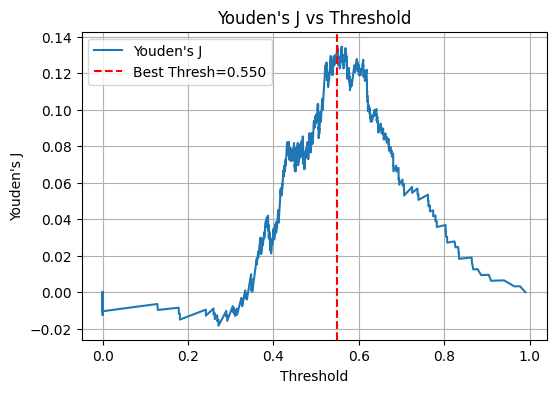

Optimal classification threshold based on Youden's J statistic: 0.550
Maximum Youden's J value (Sensitivity + Specificity - 1): 0.1351
Sensitivity at best threshold: 0.3475
Specificity at best threshold: 0.7876


In [ ]:
col_indices = [feature_names.index(f) for f in used_features_test]
y_scores = logreg_model_test.predict_proba(X_test[:, col_indices])[:, 1]
best_thresh, best_youden_j, sensitivity, specificity = find_optimal_threshold_youden(y_test, y_scores)
print(f"Optimal classification threshold based on Youden's J statistic: {best_thresh:.3f}")
print(f"Maximum Youden's J value (Sensitivity + Specificity - 1): {best_youden_j:.4f}")
print(f"Sensitivity at best threshold: {sensitivity:.4f}")
print(f"Specificity at best threshold: {specificity:.4f}")


Confusion matrix counts at threshold 0.56: TP=96, TN=27453, FP=6139, FN=209

PRS: p26267 summary stats by group:
               mean       std  count
cm_group                           
FN        0.812011  1.030963    199
FP        0.136390  0.999858   6017
TN        0.159229  0.994434  26604
TP        0.725313  0.959358     95

PRS: p26268 summary stats by group:
               mean       std  count
cm_group                           
FN        0.530342  1.076549     51
FP        0.122103  1.010017   1771
TN        0.116807  1.035090   7489
TP        0.756062  0.997248     29


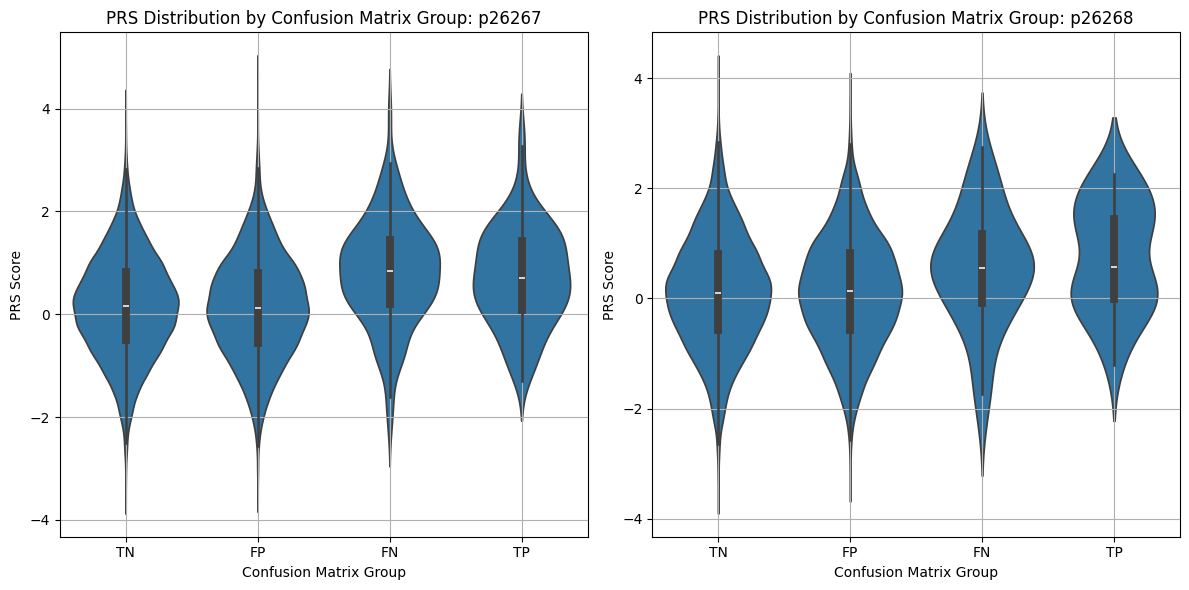

In [ ]:
results,df_merged  = prs_confusion_matrix_analysis(
    model=logreg_model_test,
    X_test=X_test,
    y_test=y_test,
    eids_test=eids_test,
    prs_csv_path="prs.csv",
    feature_names=feature_names,
    selected_features=used_features_test,
    threshold=0.56
)



In [ ]:
prs_TP = df_merged.loc[df_merged['cm_group'] == 'TP', 'p26267'].dropna().values
prs_TN = df_merged.loc[df_merged['cm_group'] == 'TN', 'p26267'].dropna().values
prs_FP = df_merged.loc[df_merged['cm_group'] == 'FP', 'p26267'].dropna().values
prs_FN = df_merged.loc[df_merged['cm_group'] == 'FN', 'p26267'].dropna().values


In [ ]:
from scipy.stats import kruskal, mannwhitneyu
import itertools
import pandas as pd

prs_columns = ['p26267', 'p26268']  # Your two PRS columns

for prs_col in prs_columns:
    prs_TP = df_merged.loc[df_merged['cm_group'] == 'TP', prs_col].dropna().values
    prs_TN = df_merged.loc[df_merged['cm_group'] == 'TN', prs_col].dropna().values
    prs_FP = df_merged.loc[df_merged['cm_group'] == 'FP', prs_col].dropna().values
    prs_FN = df_merged.loc[df_merged['cm_group'] == 'FN', prs_col].dropna().values

    prs_df = pd.DataFrame({
        'PRS_value': list(prs_TP) + list(prs_TN) + list(prs_FP) + list(prs_FN),
        'cm_group': ['TP'] * len(prs_TP) + ['TN'] * len(prs_TN) + ['FP'] * len(prs_FP) + ['FN'] * len(prs_FN)
    })

    groups = [prs_df.loc[prs_df['cm_group'] == g, 'PRS_value'] for g in ['TP', 'TN', 'FP', 'FN']]
    stat, p = kruskal(*groups)
    print(f"\nKruskal-Wallis test for {prs_col}: H-statistic = {stat:.4f}, p-value = {p:.4e}")

    if p < 0.05:
        print("Significant differences detected. Running pairwise Mann-Whitney U tests:")
        groups_names = ['TP', 'TN', 'FP', 'FN']
        prs_groups = {g: prs_df.loc[prs_df['cm_group'] == g, 'PRS_value'] for g in groups_names}

        for g1, g2 in itertools.combinations(groups_names, 2):
            stat_u, p_u = mannwhitneyu(prs_groups[g1], prs_groups[g2], alternative='two-sided')
            print(f"  Mann-Whitney U test {g1} vs {g2}: U={stat_u}, p={p_u:.4e}")
    else:
        print("No significant differences between groups.")



Kruskal-Wallis test for p26267: H-statistic = 110.3047, p-value = 9.4353e-24
Significant differences detected. Running pairwise Mann-Whitney U tests:
  Mann-Whitney U test TP vs TN: U=1661919.5, p=1.0935e-07
  Mann-Whitney U test TP vs FP: U=379194.5, p=4.4342e-08
  Mann-Whitney U test TP vs FN: U=8879.0, p=4.0062e-01
  Mann-Whitney U test TN vs FP: U=81152539.5, p=9.1156e-02
  Mann-Whitney U test TN vs FN: U=1684705.0, p=8.7523e-19
  Mann-Whitney U test FP vs FN: U=374854.0, p=2.5403e-19

Kruskal-Wallis test for p26268: H-statistic = 18.3313, p-value = 3.7579e-04
Significant differences detected. Running pairwise Mann-Whitney U tests:
  Mann-Whitney U test TP vs TN: U=144721.0, p=1.9537e-03
  Mann-Whitney U test TP vs FP: U=34240.0, p=2.0480e-03
  Mann-Whitney U test TP vs FN: U=809.0, p=4.8983e-01
  Mann-Whitney U test TN vs FP: U=6601075.0, p=7.6356e-01
  Mann-Whitney U test TN vs FN: U=145122.5, p=3.0836e-03
  Mann-Whitney U test FP vs FN: U=34511.0, p=4.0425e-03


In [ ]:

prs_columns = ['p26267', 'p26268']  # Your two PRS columns

for prs_col in prs_columns:
    # Extract PRS values by CM group for this column
    prs_TP = df_merged.loc[df_merged['cm_group'] == 'TP', prs_col].dropna().values
    prs_TN = df_merged.loc[df_merged['cm_group'] == 'TN', prs_col].dropna().values
    prs_FP = df_merged.loc[df_merged['cm_group'] == 'FP', prs_col].dropna().values
    prs_FN = df_merged.loc[df_merged['cm_group'] == 'FN', prs_col].dropna().values

    # Create DataFrame for plotting
    prs_df = pd.DataFrame({
        'PRS_value': list(prs_TN) + list(prs_FP) + list(prs_FN) + list(prs_TP),
        'cm_group': ['TN'] * len(prs_TN) + ['FP'] * len(prs_FP) + ['FN'] * len(prs_FN) + ['TP'] * len(prs_TP)
    })

    plt.figure(figsize=(12, 8))

    # Violin + boxplot
    sns.violinplot(x='cm_group', y='PRS_value', data=prs_df, order=['TN', 'FP', 'FN', 'TP'], inner=None, color=".8")
    sns.boxplot(x='cm_group', y='PRS_value', data=prs_df, order=['TN', 'FP', 'FN', 'TP'])

    # Plot group means as black dots
    groups_names = ['TN', 'FP', 'FN', 'TP']
    means = prs_df.groupby('cm_group')['PRS_value'].mean()
    for i, g in enumerate(groups_names):
        plt.scatter(i, means[g], color='black', s=60, zorder=10, label='Mean' if i==0 else "")

    plt.title(f"PRS Score Distribution by Confusion Matrix Group ({prs_col})")
    plt.xlabel("Confusion Matrix Group")
    plt.ylabel("PRS Score")
    plt.grid(True)

    prs_groups = {g: prs_df.loc[prs_df['cm_group'] == g, 'PRS_value'] for g in groups_names}
    comparisons = list(itertools.combinations(groups_names, 2))

    y_max = prs_df['PRS_value'].max()
    y_min = prs_df['PRS_value'].min()
    h = (y_max - y_min) * 0.1

    def significance_stars(p):
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return 'ns'

    summary_rows = []
    for i, (g1, g2) in enumerate(comparisons):
        stat, p = mannwhitneyu(prs_groups[g1], prs_groups[g2], alternative='two-sided')

        mean_diff = np.mean(prs_groups[g2]) - np.mean(prs_groups[g1])
        std_dev_g1 = np.std(prs_groups[g1], ddof=1)
        std_dev_g2 = np.std(prs_groups[g2], ddof=1)

        x1, x2 = groups_names.index(g1), groups_names.index(g2)
        y = y_max + h * (i + 1)
        plt.plot([x1, x1, x2, x2], [y, y + h/5, y + h/5, y], lw=1.5, c='k')
        plt.text((x1 + x2)*0.5, y + h/5, significance_stars(p), ha='center', va='bottom', color='k')

        # Add mean difference and SD annotations below significance stars
        annotation_text = f"Mean diff: {mean_diff:.2f}\nSDs: {std_dev_g1:.2f}, {std_dev_g2:.2f}"
        plt.text((x1 + x2)*0.5, y + h/10, annotation_text, ha='center', va='top', fontsize=8, color='gray')

        summary_rows.append({
            'Group 1': g1,
            'Group 2': g2,
            'Mann-Whitney U': stat,
            'p-value': p,
            'Significance': significance_stars(p),
            'Mean Difference': mean_diff,
            'Std Dev Group 1': std_dev_g1,
            'Std Dev Group 2': std_dev_g2
        })

    plt.ylim(y_min, y_max + h * (len(comparisons) + 3))
    plt.legend(loc='upper left')

    # Save violin + boxplot figure
    plt.savefig(f'PRS_distribution_by_CM_group_{prs_col}.png', dpi=300, bbox_inches='tight')
    plt.close()

    # --- Plot mean differences with SD as a separate bar chart ---

    mean_diffs = []
    std_devs = []
    for (g1, g2) in comparisons:
        mean_diff = np.mean(prs_groups[g2]) - np.mean(prs_groups[g1])
        std_dev_g1 = np.std(prs_groups[g1], ddof=1)
        std_dev_g2 = np.std(prs_groups[g2], ddof=1)
        mean_diffs.append(mean_diff)
        # Pooled SD for error bars
        pooled_sd = np.sqrt((std_dev_g1**2 + std_dev_g2**2)/2)
        std_devs.append(pooled_sd)

    plt.figure(figsize=(12, 6))
    x_labels = [f"{g1} vs {g2}" for g1, g2 in comparisons]
    x_pos = np.arange(len(comparisons))
    plt.bar(x_pos, mean_diffs, yerr=std_devs, capsize=5, color='skyblue')
    plt.xticks(x_pos, x_labels, rotation=45, ha='right')
    plt.ylabel("Mean Difference in PRS Score")
    plt.title(f"Mean Differences with SD between CM Groups ({prs_col})")
    plt.tight_layout()

    # Save bar chart figure
    plt.savefig(f'MeanDiff_SD_by_CM_group_{prs_col}.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Print summary table for this PRS column
    summary_df = pd.DataFrame(summary_rows)
    print(f"\nPairwise Mann-Whitney U Test Summary for {prs_col}:\n")
    print(summary_df)



Pairwise Mann-Whitney U Test Summary for p26267:

  Group 1 Group 2  Mann-Whitney U       p-value Significance  Mean Difference  \
0      TN      FP      81152539.5  9.115590e-02           ns        -0.022839   
1      TN      FN       1684705.0  8.752297e-19          ***         0.652782   
2      TN      TP        865460.5  1.093455e-07          ***         0.566084   
3      FP      FN        374854.0  2.540333e-19          ***         0.675620   
4      FP      TP        192420.5  4.434170e-08          ***         0.588922   
5      FN      TP         10026.0  4.006192e-01           ns        -0.086698   

   Std Dev Group 1  Std Dev Group 2  
0         0.994434         0.999858  
1         0.994434         1.030963  
2         0.994434         0.959358  
3         0.999858         1.030963  
4         0.999858         0.959358  
5         1.030963         0.959358  

Pairwise Mann-Whitney U Test Summary for p26268:

  Group 1 Group 2  Mann-Whitney U   p-value Significance  Mean D

In [ ]:


def retrain_logreg_shap_vs_coef(
    X, y, n_features, top_features_df, feature_dict=None, output_dir="results", apply_smote=True
):
    os.makedirs(output_dir, exist_ok=True)

    # Convert X to DataFrame if needed
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
        all_feature_names = top_features_df["feature"].tolist()
        for i in range(min(X.shape[1], len(all_feature_names))):
            X.rename(columns={i: all_feature_names[i]}, inplace=True)
    else:
        X = X.copy()

    # Select top features
    top_features = top_features_df["feature"].tolist()[:n_features]
    top_features = [f for f in top_features if f in X.columns]
    if not top_features:
        raise ValueError("None of the top features exist in the input data")
    X_top = X[top_features]

    # Get human-readable labels for features
    if feature_dict is not None:
        labels = [feature_dict.get(f, f) for f in top_features]
        X_top_renamed = X_top.rename(columns=feature_dict)
    else:
        labels = top_features
        X_top_renamed = X_top

    # Apply SMOTE if desired
    if apply_smote:
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_top, y)
    else:
        X_res, y_res = X_top, y

    # Train logistic regression
    model = LogisticRegression(max_iter=1000, solver='liblinear')
    model.fit(X_res, y_res)

    # Predictions and metrics
    y_pred_prob = model.predict_proba(X_top)[:, 1]
    y_pred_class = model.predict(X_top)
    metrics = {
        "roc_auc": roc_auc_score(y, y_pred_prob),
        "pr_auc": average_precision_score(y, y_pred_prob),
        "confusion_matrix": confusion_matrix(y, y_pred_class)
    }

    # ROC curve
    RocCurveDisplay.from_predictions(y, y_pred_prob)
    plt.title("ROC Curve")
    plt.savefig(os.path.join(output_dir, "roc_curve.png"), dpi=300, bbox_inches="tight")
    plt.close()

    # PR curve
    PrecisionRecallDisplay.from_predictions(y, y_pred_prob)
    plt.title("Precision-Recall Curve")
    plt.savefig(os.path.join(output_dir, "pr_curve.png"), dpi=300, bbox_inches="tight")
    plt.close()

    # Confusion Matrix
    ConfusionMatrixDisplay(confusion_matrix=metrics["confusion_matrix"]).plot()
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"), dpi=300, bbox_inches="tight")
    plt.close()

    # SHAP values (per-sample)
    explainer = shap.LinearExplainer(model, X_res, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_top)  # shape: (n_samples, n_features)

    # Save raw SHAP values
    shap_df = pd.DataFrame(shap_values, columns=labels)
    shap_df.to_csv(os.path.join(output_dir, "shap_values_per_sample.csv"), index=False)

    # SHAP summary bar plot (using mean absolute for summary only)
    plt.figure()
    shap.summary_plot(shap_values, X_top_renamed, plot_type="bar", show=False)
    plt.title("SHAP Summary (Mean Absolute Impact)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "shap_summary_bar.png"), dpi=300, bbox_inches="tight")
    plt.close()

    # SHAP beeswarm plot (per-sample contributions)
    plt.figure()
    shap.summary_plot(shap_values, X_top_renamed, plot_type="dot", show=False)
    plt.title("SHAP Value Distribution")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "shap_summary_beeswarm.png"), dpi=300, bbox_inches="tight")
    plt.close()

    # SHAP vs Beta coefficients plot (per-sample SHAP values)
    plt.figure(figsize=(10, 6))
    for i, f in enumerate(top_features):
        plt.scatter(shap_values[:, i], np.full(shap_values.shape[0], i), alpha=0.6)
    coefs = model.coef_[0]
    plt.scatter(coefs, range(len(top_features)), color='red', label='Beta Coefficients', zorder=5)
    plt.yticks(range(len(top_features)), labels)
    plt.xlabel("Value")
    plt.title("Per-sample SHAP Values vs Logistic Regression Coefficients")
    plt.legend()
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "shap_vs_beta_per_sample.png"), dpi=300, bbox_inches="tight")
    plt.close()

    # Save metrics to CSV
    metrics_df = pd.DataFrame({
        "Metric": ["ROC-AUC", "PR-AUC"],
        "Value": [metrics["roc_auc"], metrics["pr_auc"]]
    })
    metrics_df.to_csv(os.path.join(output_dir, "metrics.csv"), index=False)

    top_features_labeled = list(zip(top_features, labels))
    return model, top_features_labeled, metrics, shap_values

In [ ]:
feature_dict = {
    "p131490_dur": "Emphysema (Respiratory)",
    "p130200_dur": "Chronic Viral Hepatitis (Infectious)",
    "p30850_i0": "Testosterone",
    "p131388_dur": "Arterial Embolism & Thrombosis (Circulatory)",
    "p30720_i0": "Cystatin C",
    "p132034_dur": "Unspecified Renal Failure (Genitourinary)",
    "p130698_dur": "Other Non-Toxic Goitre (Endocrine/Metabolic)",
    "p30700_i0": "Creatinine",
    "p130704_dur": "Other Disorders of Thyroid (Endocrine/Metabolic)",
    "p30630_i0": "Apolipoprotein A",
    "p30610_i0": "Alkaline Phosphatase",
    "p131290_dur": "Hypertensive Renal Disease (Circulatory)",
    "p48_i0": "Waist Circumference",
    "p131406_dur": "Oesophageal Varices (Circulatory)",
    "p131498_dur": "Bronchiectasis (Respiratory)",
    "p131930_dur": "Myositis (Musculoskeletal)",
    "p30830_i0": "SHBG",
    "p21002_i0": "Weight",
    "p130198_dur": "Other Acute Viral Hepatitis (Infectious)",
    "p131338_dur": "Cardiomyopathy (Circulatory system disorders)",
    "p30620_i0": "Alanine Aminotransferase",
    "p130920_dur": "Nonorganic Sleep Disorders (Mental and behavioural disorders)",
    "p130836_dur": "Dementia in Alzheimer's Disease (Mental and behavioural disorders)"
}


In [ ]:
# Combine train and test sets
X_full = np.vstack([X_train, X_test])
y_full = np.concatenate([y_train, y_test])

model, top_features_labeled, metrics, shap_values = retrain_logreg_shap_vs_coef(
    X= X_full, y = y_full, n_features=18, top_features_df=top_features_df,
    feature_dict=feature_dict, output_dir="results", apply_smote=True
)